In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv("data/arrests.csv")

In [5]:
# Convertir ARREST_DATE al formato datetime
df['ARREST_DATE'] = pd.to_datetime(df['ARREST_DATE'])

# Obtener fechas mínima y máxima
min_date = df['ARREST_DATE'].min()
max_date = df['ARREST_DATE'].max()

# Mes del arresto
df['Month'] = df['ARREST_DATE'].dt.strftime('%B')

# Día de la semana del arresto
df['Day'] = df['ARREST_DATE'].dt.day_name()

df.rename(columns={
    'ARREST_BORO': 'Borough',
    'PERP_SEX': 'Sex',
    'PERP_RACE': 'Race',
    'JURISDICTION_CODE': 'Jurisdiction',
    'ARREST_DATE': 'Date',
    'ARREST_PRECINCT': 'Precint',
    'LAW_CAT_CD': 'Category',
    'AGE_GROUP': 'Age',
    'OFNS_DESC': 'Description',
    'LAW_CODE': 'Law',
    'ARREST_KEY': 'ID'
}, inplace=True)

# Filtrar filas con valores no nulos en Latitude y Longitude
df = df[df['Latitude'].notna()]
df = df[df['Longitude'].notna()]

# Reemplazar códigos de Borough por nombres
df['Borough'] = df['Borough'].replace({
    'B': 'Bronx',
    'S': 'Staten Island',
    'K': 'Brooklyn',
    'M': 'Manhattan',
    'Q': 'Queens'
}).fillna('Unknown')

# Agrupar por Borough y contar
borough_counts = df.groupby('Borough').size().reset_index(name='count')

# Reemplazar códigos de Jurisdiction
df['Jurisdiction'] = df['Jurisdiction'].replace({
    0: 'Patrol',
    1: 'Transit',
    2: 'Housing'
}).fillna('Other')

# Reemplazar códigos de Category
df['Category'] = df['Category'].replace({
    'F': 'Felony',
    'M': 'Misdemeanor',
    'V': 'Violation',
    'I': 'Infraction'
}).fillna('Unknown')

# Agrupar por Category y contar
category_counts = df.groupby('Category').size().reset_index(name='count')

# Agrupar por Race y contar
race_counts = df.groupby('Race').size().reset_index(name='count').sort_values(by='count', ascending=False)

# Imputar valores faltantes en Race
df['Race'] = np.where(
    df['Race'].isin([
        'AMERICAN INDIAN/ALASKAN NATIVE', 'ASIAN / PACIFIC ISLANDER',
        'BLACK', 'BLACK HISPANIC', 'OTHER', 'WHITE', 'WHITE HISPANIC'
    ]),
    df['Race'],
    'BLACK'
)

# Agrupar por Age y contar
age_counts = df.groupby('Age').size().reset_index(name='count').sort_values(by='count', ascending=False)
copia = df.copy()
copia['Age'] = np.where(
    copia['Age'].isin(['<18', '18-24', '25-44', '45-64', '65+']),
    'No missing',
    'Missing')

# Código de ofensa con más valores "Missing" en Age
missing_age_mode = (
    copia[copia['Age'] == 'Missing']
    .groupby('KY_CD')
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
    .iloc[0]['KY_CD']
)

# Imputar valores faltantes en Age
df['Age'] = np.where(
    df['Age'].isin(['<18', '18-24', '25-44', '45-64', '65+']),
    df['Age'],
    '25-44'
)

# Imputar valores faltantes en KY_CD
df['KY_CD'] = df['KY_CD'].fillna(235)

# Eliminar registros con nulos en cualquier columna
df = df.dropna()

# Reiniciar el índice después de eliminar registros
df = df.reset_index(drop=True)

In [6]:
##OUTLIERS 

# Dividir el DataFrame en dos: outliers y no outliers según Latitude
outliers_lat = df[df['Latitude'] > 41]
no_outliers_lat = df[df['Latitude'] <= 41]

# Calcular la mediana de Latitude para cada Borough
borough_medians = df.groupby('Borough')['Latitude'].median()

# Imputar los valores outliers con la mediana de Latitude según Borough
outliers_lat['Latitude'] = outliers_lat['Borough'].map(borough_medians)

# Asegurarse de que Latitude es numérica
outliers_lat['Latitude'] = pd.to_numeric(outliers_lat['Latitude'])

# Concatenar nuevamente los dfFrames
df = pd.concat([outliers_lat, no_outliers_lat])

C:\Users\peric\AppData\Local\Temp\ipykernel_24776\1161540238.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_lat['Latitude'] = outliers_lat['Borough'].map(borough_medians)
C:\Users\peric\AppData\Local\Temp\ipykernel_24776\1161540238.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_lat['Latitude'] = pd.to_numeric(outliers_lat['Latitude'])


In [7]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Specify categorical columns y Convertir los valores numéricos en 'Jurisdiction' a strings
df['Jurisdiction'] = df['Jurisdiction'].apply(lambda x: str(x) if isinstance(x, (int, float)) else x)
categorical_columns = ['Category', 'Borough', 'Jurisdiction', 'Age', 'Sex', 'Race']


encoder = OneHotEncoder(sparse_output=False, drop='first')

categorical_encoded = pd.DataFrame(
    encoder.fit_transform(df[categorical_columns]),
    columns=encoder.get_feature_names_out(categorical_columns),
    index=df.index
)

df = pd.concat([df.drop(columns=categorical_columns), categorical_encoded], axis=1)

In [8]:
numerical_columns = ['Law','Precint', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude','Day','Month']
df[numerical_columns] = df[numerical_columns].apply(pd.to_numeric, errors='coerce')

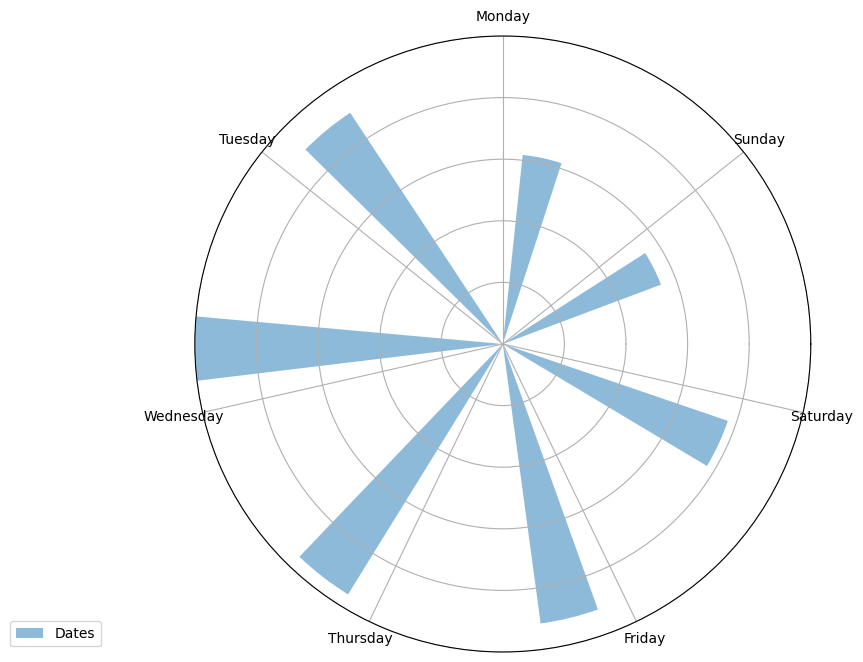

In [9]:
import pycircular
import matplotlib.pyplot as plt

time_segment = 'dayweek'  
freq_arr, times = pycircular.utils.freq_time(df['Date'] , time_segment=time_segment)
fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

plt.show()

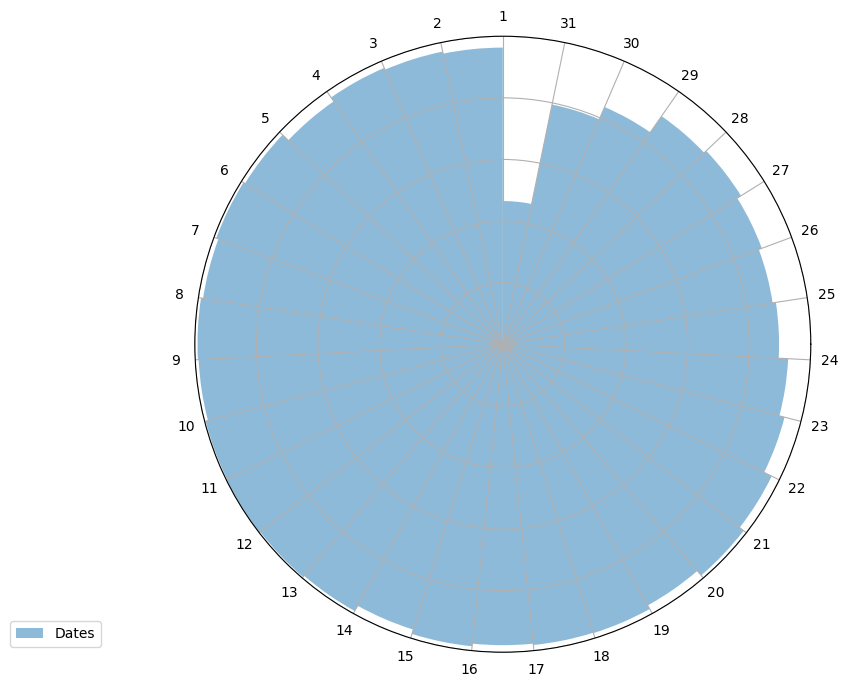

In [10]:
time_segment = 'daymonth'  
freq_arr, times = pycircular.utils.freq_time(df['Date'] , time_segment=time_segment)
fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

plt.show()

In [11]:
import numpy as np
import pandas as pd

# Asegúrate de que la columna "Date" esté en formato datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extraer el día del año (1-365 o 1-366)
df['day_of_year'] = df['Date'].dt.dayofyear

# Generar las variables seno y coseno
df['sin_day'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['cos_day'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

# Si trabajas con años bisiestos, puedes ajustar el cálculo para 366 días

In [13]:
df.to_csv("arrests_procesado_ST.csv", index=False)